🔀 Scramble Applied: ['F', 'R', 'U', "R'", "U'", "F'"]


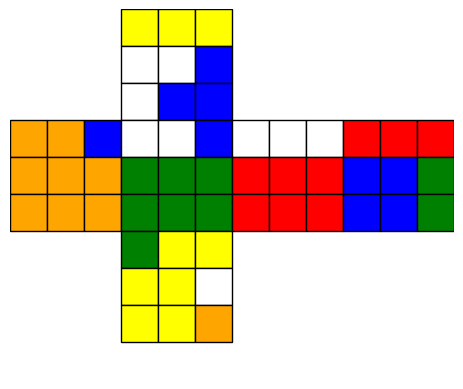

 Solving with IDA*...
 Solution: ['F', 'U', "R'", "R'", "R'", "U'", 'R', 'R', 'R', 'F', 'F', 'F']
 Time Taken: 35.6969 seconds


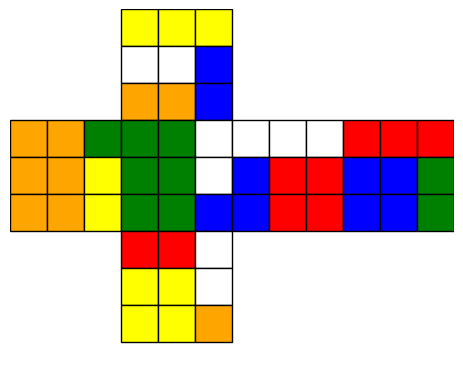

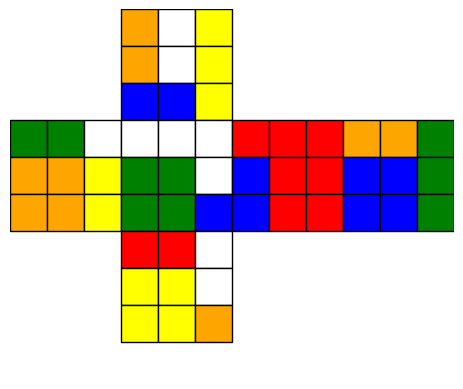

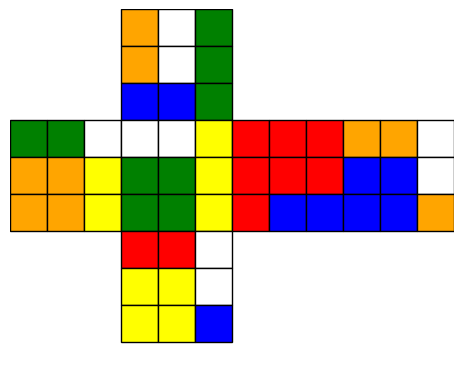

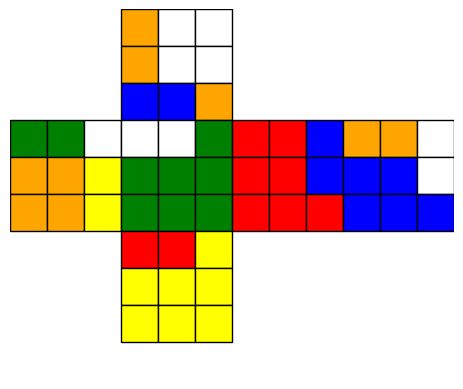

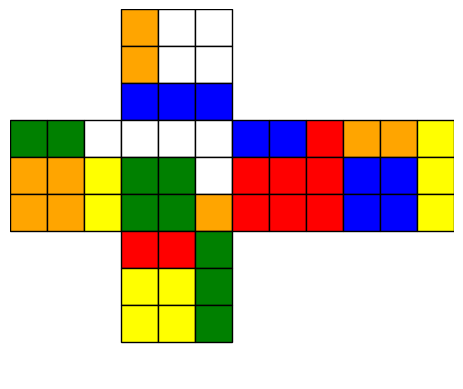

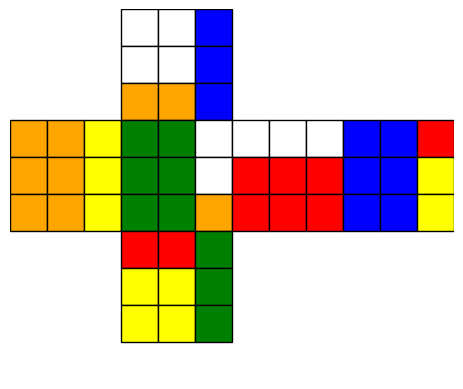

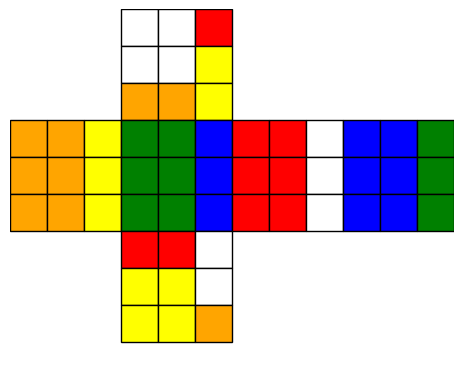

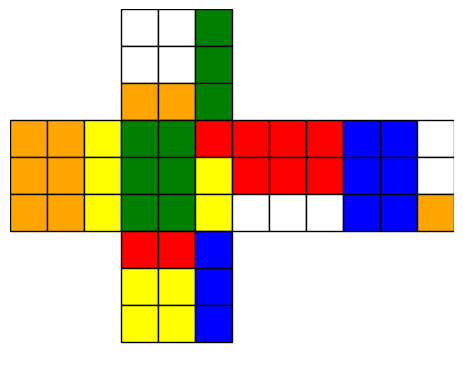

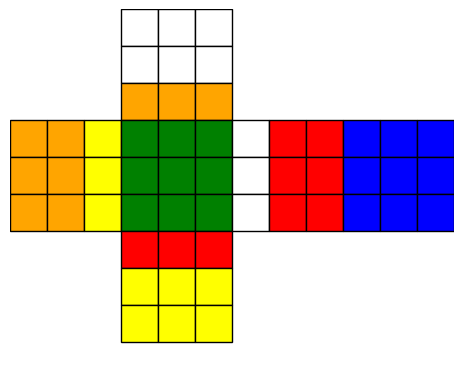

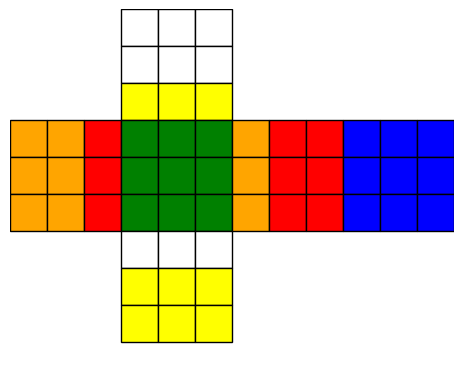

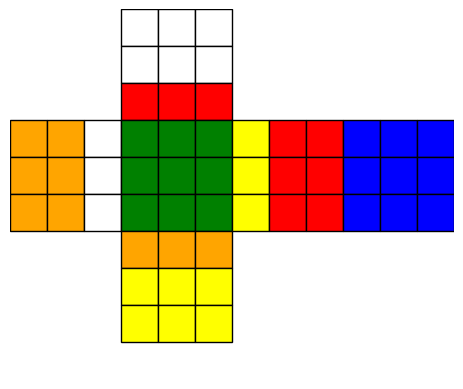

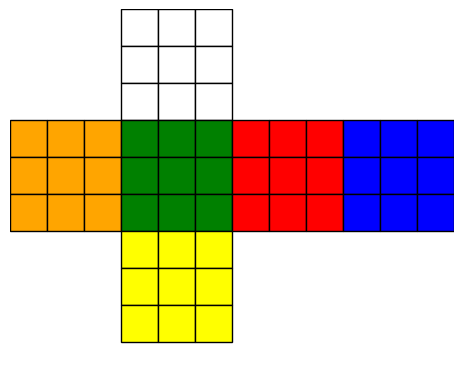

In [9]:
# Rubik's Cube Solver - AeroHack’25

import copy
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import deque

#  Face colors
COLORS = {
    'U': 'white', 'D': 'yellow',
    'F': 'green', 'B': 'blue',
    'L': 'orange', 'R': 'red'
}

#  Face positions for plotting
FACE_POS = {
    'U': (3, 6), 'L': (0, 3), 'F': (3, 3),
    'R': (6, 3), 'B': (9, 3), 'D': (3, 0)
}

class Cube:
    def __init__(self):
        self.state = {face: [[face]*3 for _ in range(3)] for face in COLORS}

    def copy(self):
        new_cube = Cube()
        new_cube.state = copy.deepcopy(self.state)
        return new_cube

    def rotate_face(self, face, clockwise=True):
        f = self.state[face]
        if clockwise:
            self.state[face] = [list(row) for row in zip(*f[::-1])]
        else:
            self.state[face] = [list(row) for row in zip(*f)][::-1]

    def apply_move(self, move):
        move_map = {
            'U': self._move_U, "U'": lambda: self._move_U(clockwise=False),
            'R': self._move_R, "R'": lambda: self._move_R(clockwise=False),
            'F': self._move_F, "F'": lambda: self._move_F(clockwise=False),
        }
        if move in move_map:
            move_map[move]()

    def is_solved(self):
        return all(all(cell == row[0] for cell in row) for face in self.state.values() for row in face)

    def to_str(self):
        return ''.join(c for face in self.state.values() for row in face for c in row)

    def _move_U(self, clockwise=True):
        self.rotate_face('U', clockwise)
        seq = ['B', 'R', 'F', 'L'] if clockwise else ['L', 'F', 'R', 'B']
        rows = [self.state[f][0][:] for f in seq]
        for i in range(4):
            self.state[seq[i]][0] = rows[(i - 1) % 4]

    def _move_R(self, clockwise=True):
        self.rotate_face('R', clockwise)
        seq = [('U', 0, 2), ('F', 0, 2), ('D', 0, 2), ('B', 2, 0)]
        cols = []
        for f, i, j in seq:
            col = [self.state[f][x][j if f != 'B' else 2 - j] for x in range(3)]
            cols.append(col)
        for i, (f, row, col) in enumerate(seq):
            for x in range(3):
                j = col if f != 'B' else 2 - col
                self.state[f][x][j] = cols[(i - 1) % 4][x]

    def _move_F(self, clockwise=True):
        self.rotate_face('F', clockwise)
        if clockwise:
            top = self.state['U'][2]
            left = [row[2] for row in self.state['L']]
            bottom = self.state['D'][0]
            right = [row[0] for row in self.state['R']]
            self.state['U'][2] = left[::-1]
            for i in range(3): self.state['L'][i][2] = bottom[i]
            self.state['D'][0] = right[::-1]
            for i in range(3): self.state['R'][i][0] = top[i]
        else:
            top = self.state['U'][2]
            right = [row[0] for row in self.state['R']]
            bottom = self.state['D'][0]
            left = [row[2] for row in self.state['L']]
            self.state['U'][2] = right
            for i in range(3): self.state['R'][i][0] = bottom[::-1][i]
            self.state['D'][0] = left
            for i in range(3): self.state['L'][i][2] = top[::-1][i]

class IDAStarSolver:
    def __init__(self, cube):
        self.start = cube
        self.moves = ['U', "U'", 'R', "R'", 'F', "F'"]

    def heuristic(self, cube):
        count = 0
        for face, grid in cube.state.items():
            expected = face
            for row in grid:
                count += sum(1 for c in row if c != expected)
        return count

    def dfs(self, cube, path, g, threshold):
        f = g + self.heuristic(cube)
        if f > threshold:
            return f
        if cube.is_solved():
            return path
        min_threshold = float('inf')
        for move in self.moves:
            next_cube = cube.copy()
            next_cube.apply_move(move)
            if len(path) > 1 and move == self.inverse(path[-1]):
                continue
            result = self.dfs(next_cube, path + [move], g + 1, threshold)
            if isinstance(result, list):
                return result
            min_threshold = min(min_threshold, result)
        return min_threshold

    def inverse(self, move):
        return move[:-1] if move.endswith("'") else move + "'"

    def ida_star(self):
        threshold = self.heuristic(self.start)
        while True:
            result = self.dfs(self.start, [], 0, threshold)
            if isinstance(result, list):
                return result
            if result == float('inf'):
                return []
            threshold = result

class Visualizer:
    def __init__(self):
        pass

    def draw(self, cube):
        fig, ax = plt.subplots()
        ax.axis('off')
        for face in FACE_POS:
            x_off, y_off = FACE_POS[face]
            for i in range(3):
                for j in range(3):
                    color = COLORS[cube.state[face][i][j]]
                    rect = plt.Rectangle((x_off + j, y_off - i), 1, 1, facecolor=color, edgecolor='black')
                    ax.add_patch(rect)
        ax.set_xlim(0, 12)
        ax.set_ylim(-3, 7)
        plt.gca().set_aspect('equal')
        plt.show()

#  Custom scramble input
user_input = "F R U R' U' F'"
scramble_seq = user_input.strip().split()

#  Create cube & apply scramble
cube = Cube()
for move in scramble_seq:
    cube.apply_move(move)

viz = Visualizer()
print("🔀 Scramble Applied:", scramble_seq)
viz.draw(cube)

#  Solve using IDA*
solver = IDAStarSolver(cube)
print(" Solving with IDA*...")
start_time = time.time()
sol_path = solver.ida_star()
end_time = time.time()

print(" Solution:", sol_path)
print(f" Time Taken: {end_time - start_time:.4f} seconds")

#  Animate the solving steps
solving = cube.copy()
for move in sol_path:
    solving.apply_move(move)
    viz.draw(solving)
    time.sleep(0.5)